В этом модуле мы будем решать задачу классификации: 

классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Скачать набор данных можно здесь. С подробным описанием датасета и столбцов таблицы ознакомьтесь в источнике.

In [74]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
 
from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
plt.style.use('seaborn') # стиль отрисовки seaborn
%matplotlib inline

In [75]:
water_data = pd.read_csv('data/water_potability.zip')
water_data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

In [76]:
TARGET_FEATURE = 'Potability'

In [77]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [78]:
colums_with_null = (water_data.isnull().mean() * 100).round(2)
colums_with_null


ph                 14.99
Hardness            0.00
Solids              0.00
Chloramines         0.00
Sulfate            23.84
Conductivity        0.00
Organic_carbon      0.00
Trihalomethanes     4.95
Turbidity           0.00
Potability          0.00
dtype: float64

Получаю список признаков в которых есть пропуски 

In [79]:
null_columns = list(colums_with_null[colums_with_null > 0].index)
null_columns

['ph', 'Sulfate', 'Trihalomethanes']

Итак, у нас отсутствует:
- около 15 % информации о кислотности воды (ph), 
- около 24 % — о содержании сульфатов (Sulfate) 
- около 5 % — о тригалометанах (Trihalomethanes). 

Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). 

Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [80]:
# В цикле заполняю пропуски медианным значением в разрезе целевого признака
for col in null_columns:
    # Заполняем пропуски
    water_data[col] = water_data[col].fillna(water_data.groupby(TARGET_FEATURE)[col].transform('median'))

Теперь проблема пропусков устранена. 

Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [81]:
X, y = water_data.drop(TARGET_FEATURE, axis=1), water_data[TARGET_FEATURE]

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

In [82]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [84]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(f'Train hold-out accuracy: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'Valid hold-out accuracy: {metrics.accuracy_score(y_valid, y_valid_pred):.2f}') 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [85]:
# разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [86]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


# K-FOLD

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

In [87]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# Создаём словарь с пустыми списками для хранения тренировочных и валидационных метрик
metrics_map = {
    'train': [],
    'valid': []
    }

# Организуем цикл для кросс-валидации (используем весь набор данных)
# train_index — индексы тренировочной выборки
# valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    # Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
    # Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    
    # Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Рассчитываем метрики и заносим их в список
    metrics_map['train'].append(metrics.accuracy_score(y_train, y_train_pred))
    metrics_map['valid'].append(metrics.accuracy_score(y_valid, y_valid_pred))

Списки со значением метрик на каждом фолде

In [88]:
print(metrics_map['train'])
print(metrics_map['valid'])

[0.8213740458015267, 0.8168637924456315, 0.8096146508966043, 0.8057993132392217, 0.8031285768790538]
[0.7713414634146342, 0.7984732824427481, 0.76793893129771, 0.7282442748091603, 0.766412213740458]


Для агрегированной оценки рассчитаем среднее значение метрик:

In [89]:
print(f'Train k-fold mean accuracy: {np.mean(metrics_map["train"]):.2f}')
print(f'Valid k-fold mean accuracy: {np.mean(metrics_map["valid"]):.2f}')

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.77


### На самом весь приведённый выше код можно значительно сократить,
### если использовать специальную функцию для кросс-валидации

In [90]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
 
# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

cv_metrics

{'fit_time': array([0.02809882, 0.02749801, 0.0277102 , 0.02769876, 0.02742124]),
 'score_time': array([0.00298667, 0.00197649, 0.00126266, 0.0014255 , 0.00153494]),
 'test_score': array([0.77134146, 0.79847328, 0.76793893, 0.72824427, 0.76641221]),
 'train_score': array([0.82137405, 0.81686379, 0.80961465, 0.80579931, 0.80312858])}

In [91]:
print(f'Train k-fold mean accuracy: {np.mean(cv_metrics["train_score"]):.2f}')
print(f'Test k-fold mean accuracy: {np.mean(cv_metrics["test_score"]):.2f}')

Train k-fold mean accuracy: 0.81
Test k-fold mean accuracy: 0.77


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

## LEAVE-ONE-OUT

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер  равняется размеру всей выборки , где  — количество примеров (строк в таблице).

Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [92]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
# Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X.iloc[:500], # матрица наблюдений X
    y=y.iloc[:500], # вектор ответов y
    cv=loo, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


### Дисбаланс выборки

In [93]:
water_data[TARGET_FEATURE].value_counts(normalize=True)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

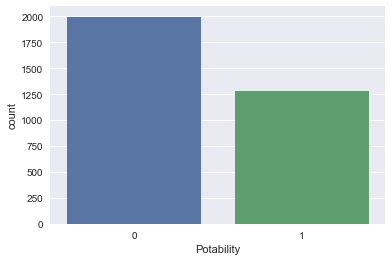

In [94]:
sns.countplot(data=water_data, x=TARGET_FEATURE)
plt.show()

Выборка была несбалансированной. Для такой выборки нельзя использовать метрику accuracy.

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [95]:
X, y = water_data.drop(TARGET_FEATURE, axis=1), water_data[TARGET_FEATURE]

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, 

в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [96]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. 

In [97]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Тут перемешивание по умолчанию выключено, в отличии от train_test_split

for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов.

Для того чтобы задать веса классам по приведённым выше формулам, 

достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [98]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       666
           1       0.69      0.65      0.67       426

    accuracy                           0.75      1092
   macro avg       0.74      0.73      0.74      1092
weighted avg       0.75      0.75      0.75      1092



### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ
Следующий метод, о котором мы поговорим, — это выбор порога вероятности (бинаризации).

PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Перед построением PR-кривой нам необходимо предсказать вероятности принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [99]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел 
)

# Обучаем модель
model.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [100]:
y_cv_proba_pred

array([[0.68103448, 0.31896552],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [101]:
# Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]
y_cv_proba_pred

array([0.31896552, 0.        , 0.        , ..., 1.        , 1.        ,
       1.        ])

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [102]:
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

# Посмотрим на первые пять значений
print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:', recall[:5])

Thresholds: [0.         0.03508772 0.05263158 0.07142857 0.07692308]
Precision scores: [0.39010989 0.49072412 0.4945322  0.49421085 0.49359365]
Recall scores: [1.         0.96244131 0.95539906 0.95187793 0.94953052]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна.

Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F1-score.

Best threshold = 0.29, F1-Score = 0.66


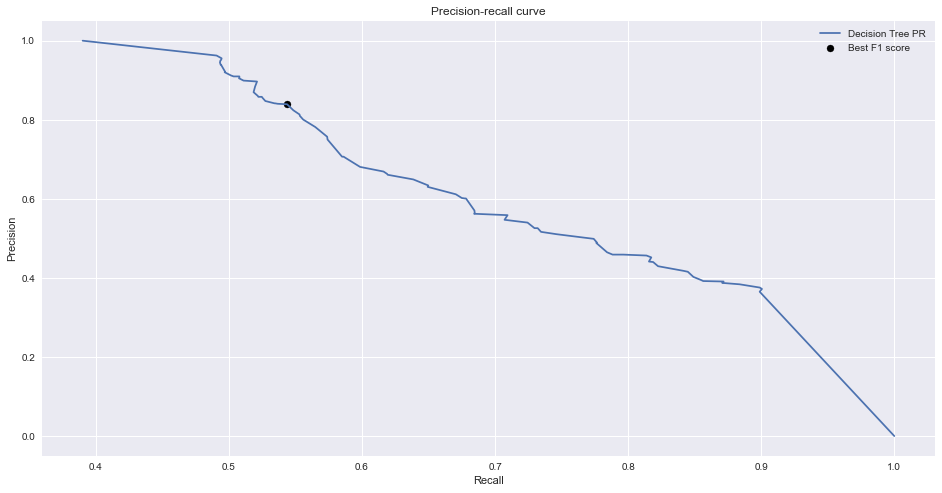

In [103]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)

# Определяем индекс максимума F1
idx = np.argmax(f1_scores)
# И значение порога вероятности при котором F1 максимален
threshold_opt = thresholds[idx]

print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(threshold_opt, f1_scores[idx]))
 
# Строим PR-кривую
fig, ax = plt.subplots(figsize = (16, 8)) # фигура + координатная плоскость

# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')

# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')

# Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

#Отображаем легенду
ax.legend()
plt.show()

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум  F1 = 0.69 на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [104]:
# Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
# В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')

# Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       666
           1       0.58      0.83      0.68       426

    accuracy                           0.70      1092
   macro avg       0.72      0.72      0.70      1092
weighted avg       0.75      0.70      0.70      1092



Итак, при применении метода подбора вероятности увеличилось значение метрик recall и  F1 для класса 1.

Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn.

В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности

In [105]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.75


### СЭМПЛИРОВАНИЕ
Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. 

Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. 

Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).

In [106]:
# !pip install imbalanced-learn

In [107]:
from imblearn.over_sampling import SMOTE

In [108]:
# Создадим объект класса SMOTE и вызовем у него метод fit_sample(), 
# передав в него обучающую выборку (X_train, y_train). 
# Затем выведем количество наблюдений каждого из классов до и после сэмплирования:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2184, 9)
Class balance before oversampling: 
0    1332
1     852
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (2664, 9)
Class balance after oversampling: 
0    1332
1    1332
Name: Potability, dtype: int64


Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке

(обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [109]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75       666
           1       0.61      0.69      0.65       426

    accuracy                           0.71      1092
   macro avg       0.70      0.70      0.70      1092
weighted avg       0.71      0.71      0.71      1092



Заметьте, что качество всех рассмотренных методов приблизительно одинаковое — они дают примерно идентичное значение метрик. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.

### КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией 

в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. 

Сделаем предсказание для каждой из выборок и рассчитаем метрику F1-score:

In [110]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    class_weight='balanced', # веса классов
    random_state=42 # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)

# Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
# Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


In [111]:
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       400
           1       0.70      0.64      0.67       256

    accuracy                           0.75       656
   macro avg       0.74      0.73      0.74       656
weighted avg       0.75      0.75      0.75       656



Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. 

Организуем стратифицированную кросс-валидацию на пяти фолдах. 

На каждом шаге кросс-валидации будем вычислять метрику  на тренировочных и валидационных фолдах.

In [112]:
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # В кросс-валидаторе лучше выставлять shuffle в True так идет меньше подстройка под серийость
 
# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

cv_metrics

{'fit_time': array([0.04013181, 0.0350337 , 0.03808975, 0.04115701, 0.04003525]),
 'score_time': array([0.0030005 , 0.00305343, 0.00200272, 0.00375867, 0.00403404]),
 'test_score': array([0.64661654, 0.6855792 , 0.67149758, 0.63657957, 0.66183575]),
 'train_score': array([1., 1., 1., 1., 1.])}

Подсчитаем среднее значение F1-score на выборках:

In [113]:
print(f'Train k-fold mean f1: {np.mean(cv_metrics["train_score"]):.2f}')
print(f'Valid k-fold mean f1: {np.mean(cv_metrics["test_score"]):.2f}')

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.66


### МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

In [114]:
# Смотрим на макс глубину дерева
model_bad.get_depth()

27

Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [115]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # ограничиваем глубину дерева
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)
 
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.76
Valid k-fold mean f1: 0.69


После ограничения максимальной глубины удалось уменьшить разницу между метриками на тренировочных и валидационных фолдах кросс-валидации.

In [117]:
f1_map = {'depth': np.arange(1, 31),
          'train_F1': [],
          'valid_F1': []
          }

In [118]:
for i in f1_map['depth']:
    model = tree.DecisionTreeClassifier(
        criterion='entropy', # критерий информативности
        max_depth=i, # ограничиваем глубину дерева
        random_state=42, # генератор случайных чисел
        class_weight='balanced' # веса классов
    )
    
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=5)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=True # подсчёт метрики на тренировочных фолдах
    )
    
    f1_map['train_F1'].append(np.mean(cv_metrics['train_score']))
    f1_map['valid_F1'].append(np.mean(cv_metrics['test_score']))

In [119]:
# Результаты метрик трансформирую в датафрейм
f1_df = pd.DataFrame(f1_map)
# Добавляю столбец разницы train-valid метрик для каждого значения depth
f1_df['f1_diff'] = f1_df['valid_F1'] - f1_df['train_F1']

In [120]:
valid_max = f1_df['valid_F1'].max()
depth_for_max = f1_df['depth'].loc[f1_df['valid_F1'].idxmax()]

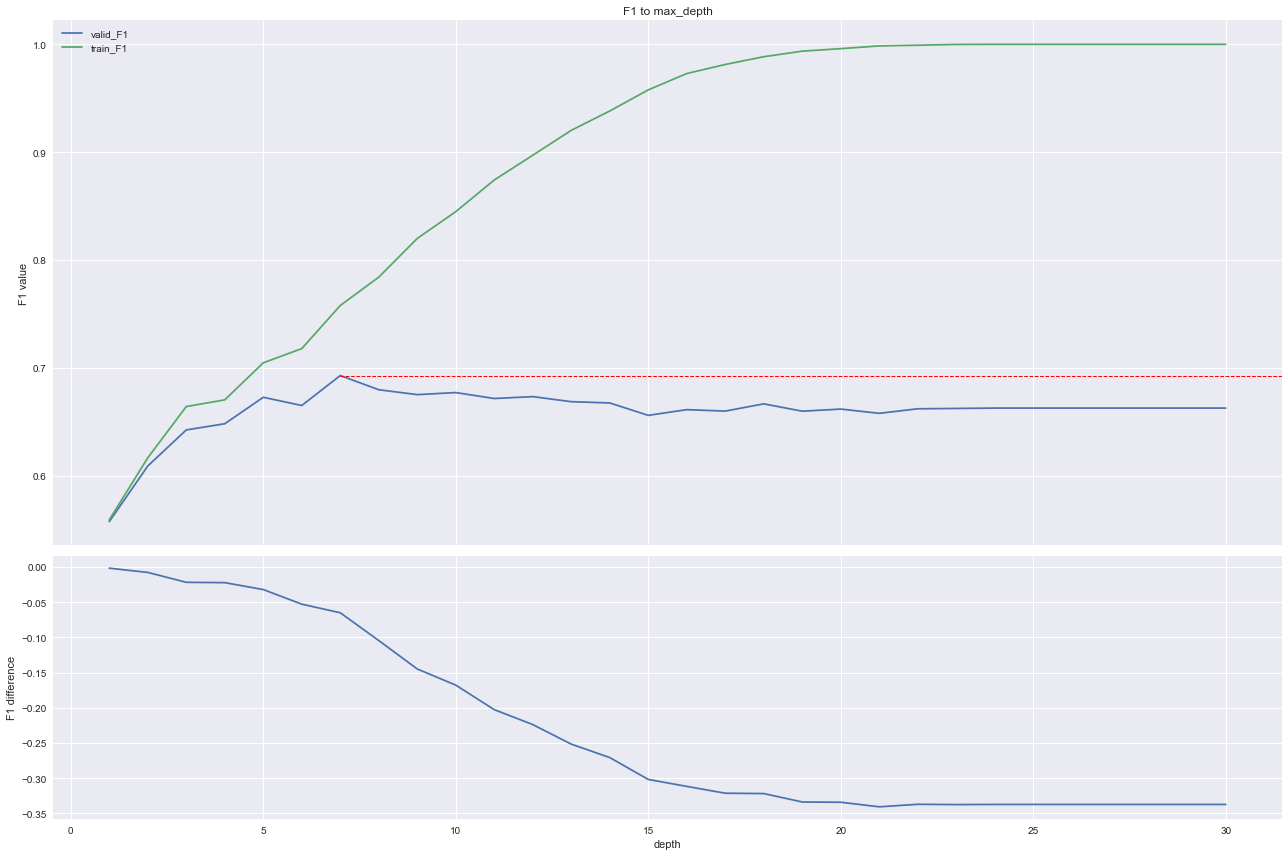

In [121]:
# Визуализируем метрики при различных значениях глубины дерева
fig, ax = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # фигура + координатная плоскость
sns.lineplot(data=f1_df, x='depth', y='valid_F1', ax=ax[0])
sns.lineplot(data=f1_df, x='depth', y='train_F1', ax=ax[0])
ax[0].set_title('F1 to max_depth')
ax[0].set_ylabel('F1 value')
ax[0].legend(labels=['valid_F1', 'train_F1'])

ax[0].axhline(y=valid_max, xmin=depth_for_max / f1_df['depth'].max(), xmax=1, ls='--', c='red', lw=1)

sns.lineplot(data=f1_df, x='depth', y='f1_diff', ax=ax[1])
ax[1].set_ylabel('F1 difference')

plt.tight_layout()
plt.show()

Нужно вбырать глубину 7. После этого значение метрики F1 на валидационной выборке уже не растет, а разница между значением метрик на тестовой и валидационной выборке продолжает увеличиваться, т.е. растет переобучение.

### Попробуем добавить ещё одно ограничение к нашему дереву: 
увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf).

По умолчанию этот параметр равен 1. 

In [122]:
f1_map = {'leafs': np.arange(1, 11),
          'train_F1': [],
          'valid_F1': [],
          }

In [123]:
for i in f1_map['leafs']:
    model = tree.DecisionTreeClassifier(
        criterion='entropy', # критерий информативности
        max_depth=5, # ограничиваем глубину дерева
        min_samples_leaf=i,
        random_state=42, # генератор случайных чисел
        class_weight='balanced' # веса классов
    )
    
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=5)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=True # подсчёт метрики на тренировочных фолдах
    )
    
    f1_map['train_F1'].append(np.mean(cv_metrics['train_score']))
    f1_map['valid_F1'].append(np.mean(cv_metrics['test_score']))

In [124]:
# Результаты метрик трансформирую в датафрейм
f1_df = pd.DataFrame(f1_map)
# Добавляю столбец разницы train-valid метрик для каждого значения leaf
f1_df['f1_diff'] = f1_df['valid_F1'] - f1_df['train_F1']

In [125]:
valid_max = f1_df['valid_F1'].max()
leafs_for_max = f1_df['leafs'].loc[f1_df['valid_F1'].idxmax()]

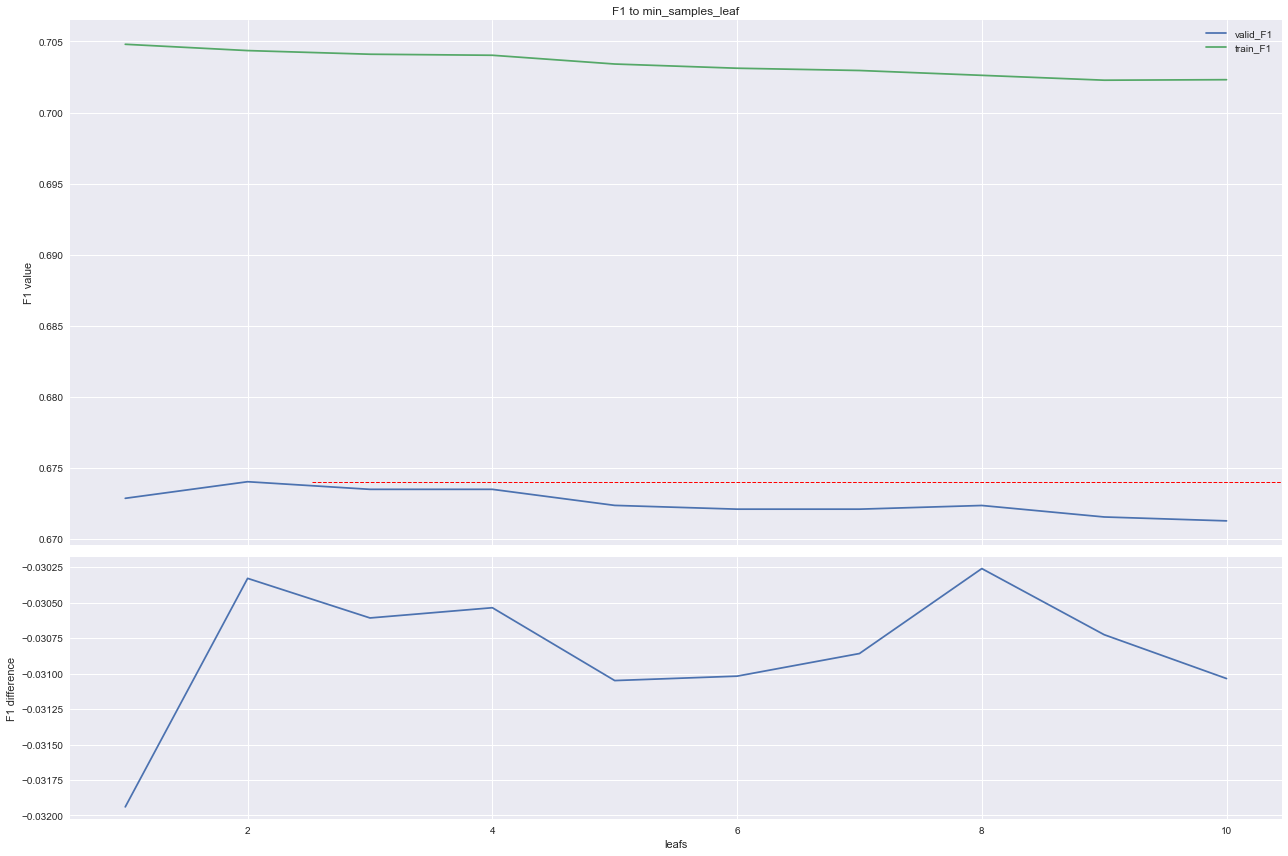

In [126]:
# Визуализируем метрики при различных значениях глубины дерева
fig, ax = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # фигура + координатная плоскость
sns.lineplot(data=f1_df, x='leafs', y='valid_F1', ax=ax[0])
sns.lineplot(data=f1_df, x='leafs', y='train_F1', ax=ax[0])
ax[0].set_title('F1 to min_samples_leaf')
ax[0].set_ylabel('F1 value')
ax[0].legend(labels=['valid_F1', 'train_F1'])

ax[0].axhline(y=valid_max, xmin=leafs_for_max / f1_df['leafs'].max(), xmax=1, ls='--', c='red', lw=1)

sns.lineplot(data=f1_df, x='leafs', y='f1_diff', ax=ax[1])
ax[1].set_ylabel('F1 difference')

plt.tight_layout()
plt.show()

5 или 8 листов надо выбирать

In [127]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=5, # ограничиваем глубину дерева
    min_samples_leaf=5,
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)
 
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.70
Valid k-fold mean f1: 0.67


### ПОСТРОЕНИЕ КРИВОЙ ОБУЧЕНИЯ

In [129]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, # генератор случайных чисел 
)
 
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
# Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, # модель
    X = X_train, # матрица наблюдений X
    y = y_train, # вектор ответов y
    cv = skf, # кросс-валидатор
    scoring = 'f1' # метрика
)

print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 209  681 1152 1624 2096]
Train scores: 
 [[0.87951807 0.87058824 0.87058824 0.87058824 0.87058824]
 [0.80070547 0.76865672 0.77442274 0.77442274 0.77442274]
 [0.77722278 0.77287406 0.76810266 0.7436182  0.7436182 ]
 [0.76474981 0.75358166 0.74096386 0.73684211 0.75737941]
 [0.75669765 0.74382022 0.76363636 0.75209849 0.75592287]]
Valid scores: 
 [[0.56737589 0.60287081 0.62829736 0.64788732 0.59472422]
 [0.62389381 0.65581395 0.58352941 0.59382423 0.6323185 ]
 [0.65106383 0.63981043 0.68172485 0.65714286 0.66666667]
 [0.67734554 0.66063348 0.64470588 0.6440678  0.66522678]
 [0.69247312 0.66509434 0.72151899 0.68534483 0.68980477]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [130]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.8723742  0.77852608 0.76108718 0.75070337 0.75443512]
Valid k-fold f1 scores [0.60823112 0.61787598 0.65928173 0.6583959  0.69084721]


Теперь можно построить графики кривых обучения:

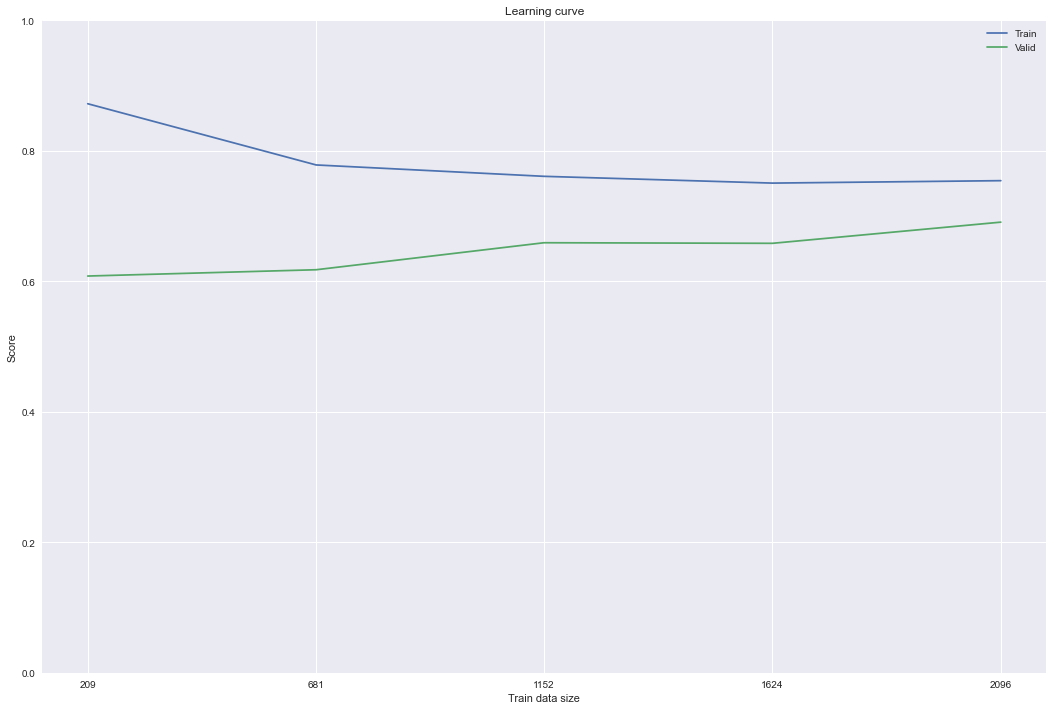

In [131]:
# Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(18, 12)) # фигура + координатная плоскость

# Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')

# Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')

# Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')

# Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)

# Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)

# Отображаем легенду
ax.legend()
plt.show()

In [133]:
learning_curve_df = pd.DataFrame({'Train size': train_sizes,
              'Train': np.mean(train_scores, axis=1),
              'Valid': np.mean(valid_scores, axis=1)})
learning_curve_df

,Train size,Train,Valid
0,209,0.872374,0.608231
1,681,0.778526,0.617876
2,1152,0.761087,0.659282
3,1624,0.750703,0.658396
4,2096,0.754435,0.690847


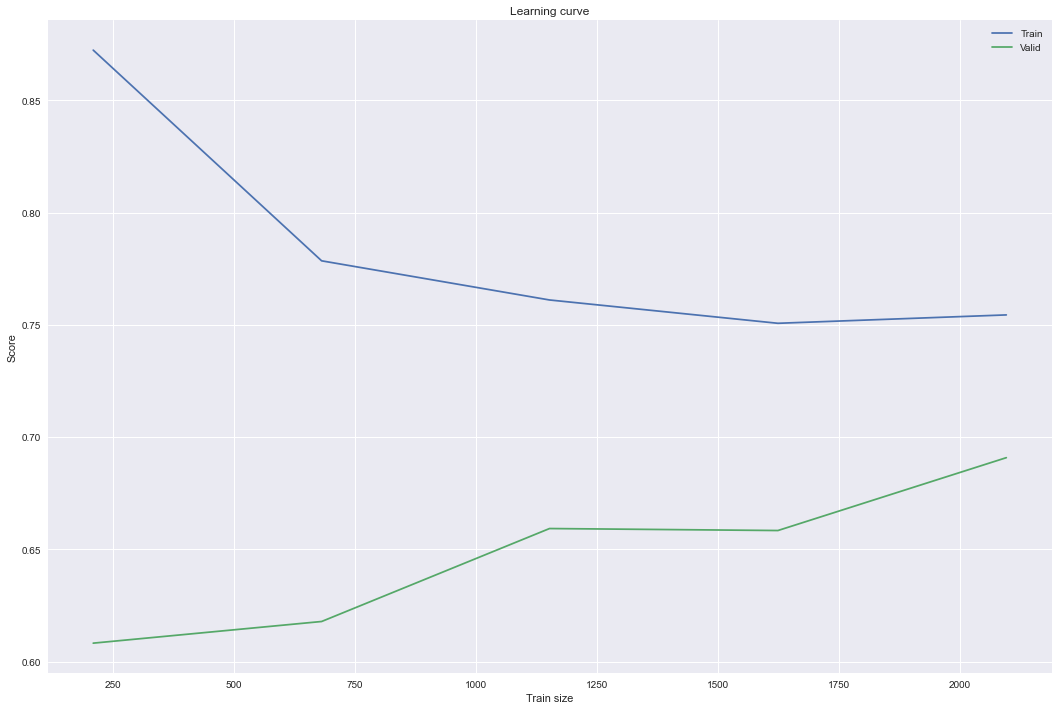

In [134]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.lineplot(data=learning_curve_df, x='Train size', y='Train', ax=ax)
sns.lineplot(data=learning_curve_df, x='Train size', y='Valid', ax=ax)

ax.set_title('Learning curve')
ax.set_ylabel('Score')

ax.legend(labels=['Train', 'Valid'])

plt.show()

Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию plot_learning_curve(). 

У функции будет несколько аргументов: 
- модель, 
- набор данных (X, y),
- кросс-валидатор, 
- метрика, 
- координатная плоскость matplotlib, на которой будет строиться график, 
- подпись графика

In [167]:
def plot_learning_curve(model, X, y, cv, scoring='f1', ax=None, title=''):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model, # модель
        X=X, # матрица наблюдений X
        y=y, # вектор ответов y
        cv=cv, # кросс-валидатор
        scoring=scoring, # метрика
        # train_sizes=[0.1, 0.25, 0.5, 0.75, 1],
        train_sizes=np.arange(0.1, 1.1, 0.1) # каждые 10%
    )
    
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 12))
        
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. 

Будем использовать следующие модели:
- логистическую регрессию,
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
- дерево решений без ограничений.

Создадим список, в котором будем хранить эти модели:

In [168]:
# Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, # количество итераций на сходимость
        random_state=42, # генератор случайных чисел
        class_weight='balanced' # веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', # критерий информативности
        max_depth=7, # максимальная глубина
        min_samples_leaf=5, # минимальное число объектов в листе
        random_state=42, # генератор случайных чисел 
        class_weight='balanced' # веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', # критерий информативности
        random_state=42, # генератор случайных чисел 
        class_weight='balanced' # веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

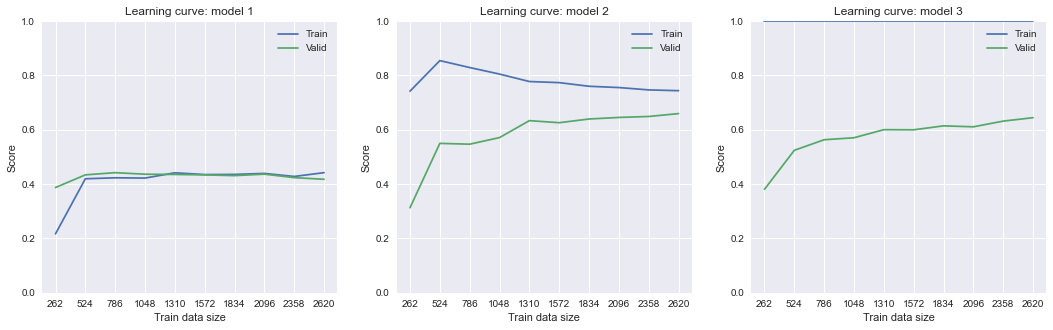

In [169]:
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # фигура + три координатных плоскости

# Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): # i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')

Благодаря построенным графикам мы можем легко сравнить три представленные модели между собой. 

Первый график, построенный для логистической регрессии, говорит нам о том, что для данной модели качество на тренировочных и валидационных фолдах практически одинаково (кривые проходят очень близко друг к другу), то есть переобучения нет. Однако данная модель обладает низким качеством: кривые не превышают даже значения 0.5. Модель является недообученнной.

Третий график, построенный для дерева решений без ограничений глубины, явно указывает на наличие переобучения: тренировочная кривая всё время находится в области своего максимума — 1, а вот валидационная кривая не может достичь такой высокой отметки.

Из всех представленных оптимальной является модель дерева решений с ограничениями, кривая обучения которой изображена на втором графике. Тренировочная и валидационная кривые постепенно сходятся к единой отметке качества, и полученная метрика превышает отметку в 0.5.